# Face Detection with MTCNN

This notebook demonstrates face detection using MTCNN (Multi-task Cascaded Convolutional Networks).

**Contents:**
1. Inference Demo - Detect faces using pretrained MTCNN
2. Dataset Exploration - Load and visualize WIDER FACE dataset
3. Fine-tuning - Train on custom data
4. Evaluation - Compare results

In [4]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

from src.model import FaceDetector
from src.utils import draw_boxes, calculate_iou, load_image
from src.dataset import WIDERFaceDataset, create_wider_face_transforms
from src.trainer import FaceDetectionTrainer

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


## Part 1: Inference Demo

Let's start by using the pretrained MTCNN model to detect faces in sample images.

In [6]:
# Initialize the face detector
detector = FaceDetector(
    device=device,
    min_face_size=20,
    thresholds=(0.6, 0.7, 0.7),
    keep_all=True,
)
print(detector)

FaceDetector(device=cuda, min_face_size=20, thresholds=(0.6, 0.7, 0.7))


In [7]:
# Helper function to load images from URL
def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

# Sample images for testing (public domain images)
sample_urls = [
    'https://images.unsplash.com/photo-1529156069898-49953e39b3ac?w=640',  # Group of people
    'https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?w=640',  # Single person
    'https://images.unsplash.com/photo-1517841905240-472988babdf9?w=640',  # Portrait
]

print('Loading sample images...')

Loading sample images...



Image 1: Detected 0 faces


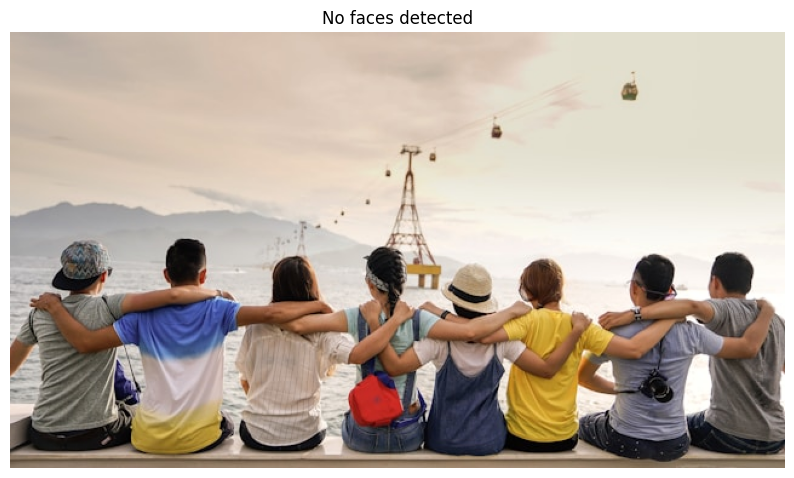


Image 2: Detected 1 faces


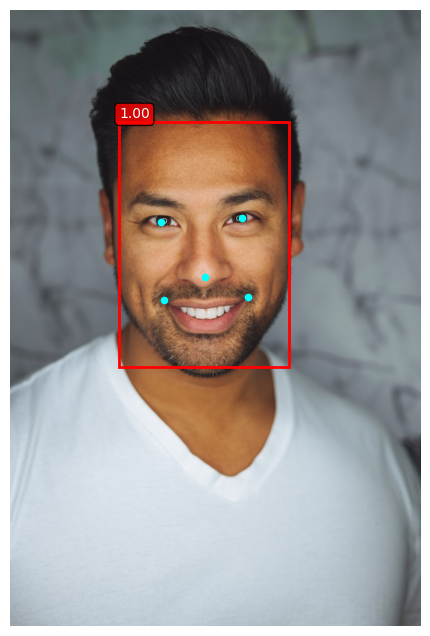


Image 3: Detected 1 faces


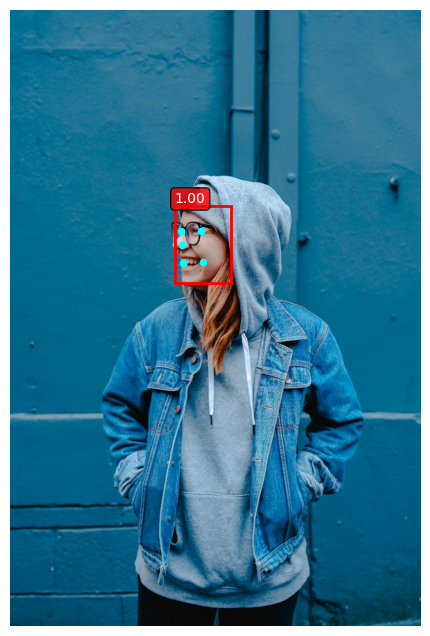

In [10]:
# Detect faces in sample images
for i, url in enumerate(sample_urls):
    try:
        # Load image
        image = load_image_from_url(url)
        
        # Detect faces
        boxes, scores, landmarks = detector.detect(image)
        
        # Visualize results
        print(f'\nImage {i+1}: Detected {len(boxes) if boxes is not None else 0} faces')
        
        if boxes is not None:
            draw_boxes(image, boxes, scores, landmarks, figsize=(10, 8))
        else:
            plt.figure(figsize=(10, 8))
            plt.imshow(image)
            plt.title('No faces detected')
            plt.axis('off')
            plt.show()
            
    except Exception as e:
        print(f'Error loading image {i+1}: {e}')

### Extracting Face Crops

MTCNN can also extract aligned face crops for face recognition pipelines.

Extracted 1 face crops of size 160x160


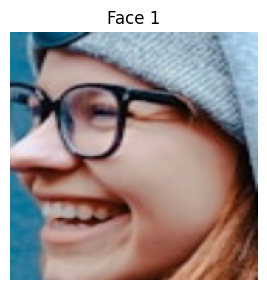

In [14]:
# Extract aligned face crops
try:
    image = load_image_from_url(sample_urls[2])
    faces = detector.extract_faces(image, return_tensors=True)
    
    if faces is not None:
        print(f'Extracted {faces.shape[0]} face crops of size {faces.shape[2]}x{faces.shape[3]}')
        
        # Display extracted faces
        n_faces = min(faces.shape[0], 5)  # Show at most 5 faces
        fig, axes = plt.subplots(1, n_faces, figsize=(3*n_faces, 3))
        if n_faces == 1:
            axes = [axes]
        
        for i in range(n_faces):
            face = faces[i].permute(1, 2, 0).cpu().numpy()
            face = (face - face.min()) / (face.max() - face.min())  # Normalize for display
            axes[i].imshow(face)
            axes[i].set_title(f'Face {i+1}')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print('No faces detected for extraction')
except Exception as e:
    print(f'Error: {e}')

### Adjusting Detection Thresholds

You can tune detection sensitivity by adjusting thresholds.

In [ ]:
# Compare different threshold settings
threshold_configs = [
    (0.6, 0.7, 0.7),  # Default
    (0.4, 0.5, 0.5),  # More sensitive (more detections, more false positives)
    (0.8, 0.9, 0.9),  # Less sensitive (fewer detections, fewer false positives)
]

try:
    image = load_image_from_url(sample_urls[0])
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, thresholds in enumerate(threshold_configs):
        detector.set_thresholds(thresholds)
        boxes, scores, _ = detector.detect(image)
        
        axes[i].imshow(image)
        if boxes is not None:
            for box in boxes:
                x1, y1, x2, y2 = box
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                     fill=False, edgecolor='red', linewidth=2)
                axes[i].add_patch(rect)
        
        n_detections = len(boxes) if boxes is not None else 0
        axes[i].set_title(f'Thresholds: {thresholds}\nDetections: {n_detections}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Reset to default
    detector.set_thresholds((0.6, 0.7, 0.7))
except Exception as e:
    print(f'Error: {e}')

## Part 2: Dataset Exploration

The WIDER FACE dataset is one of the most popular benchmarks for face detection.

**To use this section, download WIDER FACE from:** http://shuoyang1213.me/WIDERFACE/

Expected structure:
```
data/
├── WIDER_train/images/
├── WIDER_val/images/
└── wider_face_split/
    ├── wider_face_train_bbx_gt.txt
    └── wider_face_val_bbx_gt.txt
```

In [5]:
# Check if WIDER FACE dataset is available
import os

DATA_ROOT = '../data'
WIDER_AVAILABLE = os.path.exists(os.path.join(DATA_ROOT, 'wider_face_split'))

if WIDER_AVAILABLE:
    print('WIDER FACE dataset found!')
else:
    print('WIDER FACE dataset not found.')
    print('Download from: http://shuoyang1213.me/WIDERFACE/')
    print('\nSkipping dataset exploration sections...')

WIDER FACE dataset not found.
Download from: http://shuoyang1213.me/WIDERFACE/

Skipping dataset exploration sections...


In [6]:
if WIDER_AVAILABLE:
    # Load the training dataset
    train_dataset = WIDERFaceDataset(
        root=DATA_ROOT,
        split='train',
        min_size=10,
        augment=False,
    )
    
    print(f'Training samples: {len(train_dataset)}')
    
    # Dataset statistics
    total_faces = sum(len(train_dataset.samples[i]['boxes']) for i in range(len(train_dataset)))
    avg_faces = total_faces / len(train_dataset)
    print(f'Total faces: {total_faces}')
    print(f'Average faces per image: {avg_faces:.2f}')

In [7]:
if WIDER_AVAILABLE:
    # Visualize sample images with ground truth
    sample_indices = [0, 100, 500, 1000]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.flatten()
    
    for i, idx in enumerate(sample_indices):
        image, target = train_dataset[idx]
        
        # Convert tensor to numpy for display
        img_np = image.permute(1, 2, 0).numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        
        axes[i].imshow(img_np)
        
        # Draw ground truth boxes
        for box in target['boxes']:
            x1, y1, x2, y2 = box.numpy()
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                 fill=False, edgecolor='green', linewidth=2)
            axes[i].add_patch(rect)
        
        info = train_dataset.get_image_info(idx)
        axes[i].set_title(f'Sample {idx}: {info["num_faces"]} faces')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('WIDER FACE Ground Truth Samples', y=1.02, fontsize=14)
    plt.show()

In [ ]:
if WIDER_AVAILABLE:
    # Face count distribution
    face_counts = [len(train_dataset.samples[i]['boxes']) for i in range(len(train_dataset))]
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(face_counts, bins=50, edgecolor='black')
    plt.xlabel('Number of Faces')
    plt.ylabel('Number of Images')
    plt.title('Face Count Distribution')
    plt.yscale('log')
    
    plt.subplot(1, 2, 2)
    # Box sizes
    all_sizes = []
    for sample in train_dataset.samples[:1000]:  # Sample subset for speed
        for box in sample['boxes']:
            w = box[2] - box[0]
            h = box[3] - box[1]
            all_sizes.append((w + h) / 2)  # Average dimension
    
    plt.hist(all_sizes, bins=50, edgecolor='black')
    plt.xlabel('Average Face Size (pixels)')
    plt.ylabel('Count')
    plt.title('Face Size Distribution')
    
    plt.tight_layout()
    plt.show()

## Part 3: Fine-tuning

Here we demonstrate how to set up fine-tuning for the face detector.

**Note:** Full MTCNN fine-tuning is complex as it involves three cascaded networks.
This demo shows the trainer setup - for production use, consider using
specialized training frameworks.

In [8]:
if WIDER_AVAILABLE:
    from torch.utils.data import DataLoader, Subset
    
    # Create a small subset for demo
    train_subset = Subset(train_dataset, range(100))
    
    # Create transforms
    transforms = create_wider_face_transforms(train=True, image_size=(480, 480))
    
    # Create data loaders
    train_loader = DataLoader(
        train_subset,
        batch_size=4,
        shuffle=True,
        num_workers=0,
        collate_fn=WIDERFaceDataset.collate_fn,
    )
    
    print(f'Training batches: {len(train_loader)}')

In [9]:
if WIDER_AVAILABLE:
    # Initialize trainer
    trainer = FaceDetectionTrainer(
        detector=detector,
        train_loader=train_loader,
        val_loader=None,  # Add validation loader for real training
        device=device,
    )
    
    # Show MTCNN network architecture
    print('\nO-Net Architecture (Output Network):')
    print(detector.get_onet())

In [10]:
# Training demo (just 1 epoch for demonstration)
if WIDER_AVAILABLE:
    print('\nRunning training demo (1 epoch)...')
    print('Note: This is a simplified demo. Full training requires more epochs and data.')
    
    # history = trainer.fit(epochs=1)
    print('\nTraining setup complete!')
    print('Uncomment trainer.fit() to run actual training.')

## Part 4: Evaluation

Compare pretrained model performance on test samples.

In [11]:
# Evaluate on WIDER FACE samples (if available)
if WIDER_AVAILABLE:
    from src.utils import compute_precision_recall
    
    # Run evaluation on subset
    pred_boxes_list = []
    gt_boxes_list = []
    
    eval_indices = range(0, min(50, len(train_dataset)))
    
    for idx in eval_indices:
        image, target = train_dataset[idx]
        
        # Convert tensor to PIL
        img_np = image.permute(1, 2, 0).numpy()
        img_np = ((img_np - img_np.min()) / (img_np.max() - img_np.min()) * 255).astype(np.uint8)
        
        # Detect
        boxes, scores, _ = detector.detect(img_np)
        
        pred_boxes_list.append(boxes if boxes is not None else np.array([]))
        gt_boxes_list.append(target['boxes'].numpy())
    
    # Compute metrics
    precision, recall, f1 = compute_precision_recall(
        pred_boxes_list, gt_boxes_list, iou_threshold=0.5
    )
    
    print(f'\nEvaluation Results (IoU=0.5):')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

In [12]:
# Visualize predictions vs ground truth
if WIDER_AVAILABLE:
    # Select samples to visualize
    viz_indices = [0, 10, 20]
    
    fig, axes = plt.subplots(len(viz_indices), 2, figsize=(14, 6*len(viz_indices)))
    
    for i, idx in enumerate(viz_indices):
        image, target = train_dataset[idx]
        
        # Convert tensor to numpy
        img_np = image.permute(1, 2, 0).numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        
        # Detect faces
        img_uint8 = (img_np * 255).astype(np.uint8)
        boxes, scores, _ = detector.detect(img_uint8)
        
        # Ground truth (left)
        axes[i, 0].imshow(img_np)
        for box in target['boxes']:
            x1, y1, x2, y2 = box.numpy()
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                 fill=False, edgecolor='green', linewidth=2)
            axes[i, 0].add_patch(rect)
        axes[i, 0].set_title(f'Ground Truth ({len(target["boxes"])} faces)')
        axes[i, 0].axis('off')
        
        # Predictions (right)
        axes[i, 1].imshow(img_np)
        if boxes is not None:
            for j, box in enumerate(boxes):
                x1, y1, x2, y2 = box
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                     fill=False, edgecolor='red', linewidth=2)
                axes[i, 1].add_patch(rect)
                if scores is not None:
                    axes[i, 1].text(x1, y1-5, f'{scores[j]:.2f}',
                                   color='white', fontsize=8,
                                   bbox=dict(boxstyle='round', facecolor='red', alpha=0.8))
        n_pred = len(boxes) if boxes is not None else 0
        axes[i, 1].set_title(f'Predictions ({n_pred} faces)')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Ground Truth vs Predictions', y=1.01, fontsize=14)
    plt.show()

## Summary

In this notebook, we demonstrated:

1. **Inference** - Using pretrained MTCNN for face detection
2. **Face Extraction** - Getting aligned face crops for recognition pipelines  
3. **Threshold Tuning** - Adjusting detection sensitivity
4. **Dataset Loading** - Working with WIDER FACE benchmark
5. **Training Setup** - Configuring fine-tuning pipeline
6. **Evaluation** - Computing precision, recall, and F1 metrics

### Key Takeaways

- **MTCNN** is a cascaded detector with three stages (P-Net, R-Net, O-Net)
- **Thresholds** control the trade-off between precision and recall
- **WIDER FACE** is the standard benchmark for face detection
- **Fine-tuning** typically focuses on the O-Net while keeping earlier stages frozen